<a href="https://colab.research.google.com/github/austin-strom/text2face/blob/main/TFImageCap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image


In [28]:
!gdown --id 1nD6kNAgIVjxpzIScJNLqUyRA1qEkc4Op
!gdown --id 1cwcYbl0dhXEzmdbee_K_H6jcndbsxT2o         

!unzip -u -q face2text_v0.1.zip -d face2text_v0.1
!unzip -u -q face2text_v1.0.zip -d face2text_v1.0

Downloading...
From: https://drive.google.com/uc?id=1nD6kNAgIVjxpzIScJNLqUyRA1qEkc4Op
To: /content/face2text_v0.1.zip
100% 156k/156k [00:00<00:00, 36.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cwcYbl0dhXEzmdbee_K_H6jcndbsxT2o
To: /content/face2text_v1.0.zip
100% 217k/217k [00:00<00:00, 58.2MB/s]


In [29]:
# # This is moving the v0.1 file to the proper data dir for testing

!mkdir face2text_v0.1/data
# !mv face2text_v0.1/ Face2Text/.

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf lfw.tgz
!mv lfw face2text_v0.1/data/.

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Aiken/Clay_Aiken_000

In [30]:
import json
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


filename = "face2text_v0.1/clean.json"
# load descriptions
doc = load_doc(filename)
with open(filename) as f:
    annotations = json.load(f)
# jj = json.dumps(doc[1:-1])
print(annotations)
image_path = 'face2text_v0.1/data/lfw/'


[{'img_id': 1, 'image': 'Katerina_Smrzova/Katerina_Smrzova_0001.bmp', 'descriptions': [{'desc_id': 582, 'text': 'A young woman with long light brown hair cut in layers and parted in the middle, a small nose and a nice open smile.'}, {'desc_id': 1326, 'text': 'A young girl posing for the camera'}]}, {'img_id': 2, 'image': 'John_Rowland/John_Rowland_0001.bmp', 'descriptions': [{'desc_id': 178, 'text': 'Middleaged man - very traditional square jawed american features looking pensive or waiting for a result of somesort. looks like a politician'}, {'desc_id': 851, 'text': 'brown/greyish hair, brown eyes'}]}, {'img_id': 3, 'image': 'Laurent_Gbagbo/Laurent_Gbagbo_0001.bmp', 'descriptions': [{'desc_id': 815, 'text': 'A serious man, most probably politically involved. Whiting hair with intense eyes. Smart and looks important'}, {'desc_id': 1138, 'text': "Coloured man in his late 50's, dressed in suit and tie. Salt and pepper hair and round pleasant face."}, {'desc_id': 1243, 'text': 'Dark skin,

In [31]:
print(type(annotations))
print(type(annotations[0]['descriptions']))

<class 'list'>
<class 'list'>


In [32]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for img in annotations:
  for val in img['descriptions']:
    caption = f"<start> {val['text']} <end>"
    image_path_full = image_path + img['image'].replace('bmp','jpg')
    image_path_to_caption[image_path_full].append(caption)


In [33]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))
print(train_image_paths)


400
['face2text_v0.1/data/lfw/Laura_Schlessinger/Laura_Schlessinger_0001.jpg', 'face2text_v0.1/data/lfw/Cristina_Torrens_Valero/Cristina_Torrens_Valero_0001.jpg', 'face2text_v0.1/data/lfw/Anne_Krueger/Anne_Krueger_0001.jpg', 'face2text_v0.1/data/lfw/Manijeh_Hekmat/Manijeh_Hekmat_0001.jpg', 'face2text_v0.1/data/lfw/Dita_Von_Tesse/Dita_Von_Tesse_0001.jpg', 'face2text_v0.1/data/lfw/Lynne_Cheney/Lynne_Cheney_0001.jpg', 'face2text_v0.1/data/lfw/Claire_Tomalin/Claire_Tomalin_0001.jpg', 'face2text_v0.1/data/lfw/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg', 'face2text_v0.1/data/lfw/Gerhard_Boekel/Gerhard_Boekel_0001.jpg', 'face2text_v0.1/data/lfw/Bill_Paxton/Bill_Paxton_0001.jpg', 'face2text_v0.1/data/lfw/James_Young/James_Young_0001.jpg', 'face2text_v0.1/data/lfw/Dorothy_Lamour/Dorothy_Lamour_0001.jpg', 'face2text_v0.1/data/lfw/Barzan_al-Tikriti/Barzan_al-Tikriti_0001.jpg', 'face2text_v0.1/data/lfw/Lili_Taylor/Lili_Taylor_0001.jpg', 'face2text_v0.1/data/lfw/Benjamin_Netanyahu/Benjamin_Neta

In [34]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))


In [35]:
print(train_captions)
print(img_name_vector)
print(caption_list)
# Image.open(img_name_vector[0])


['<start> A 60ish year old woman with short, blonde hair, light colored eyes and a few wrinkles. <end>', '<start> a happy married lady in her 50s who seems to be picking on someone <end>', '<start> A woman probably in her 20s, with brown hair tied back, she seems to be frowned and her lips are pursed . She looks a bit angry and puzzled. <end>', '<start> face not convinced with her performance, bored look <end>', '<start> Pensive lady looking nervous and anxious. Sportsperson. <end>', '<start> A girl around 30 with long dark hair, see through her tennis racket. She is making a face while looking at the racket. <end>', '<start> She looks as if she is not agreeing with what is being said so she wants to tell her side of the story. The speaker is talking but she wants to interrupt the conversation to say her point. <end>', '<start> An old lady in her sixties , short brown hair and dark brown eyes, she wears a glasses and her seems quite disturbed <end>', '<start> A middle-aged woman with d

# Preprocess images

In [36]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


In [37]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [38]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


# Preprocess and Tokenize cations

In [39]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [40]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


In [41]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


# Split Data

In [42]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


In [43]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(992, 992, 245, 245)

# Create tf.data dataset

In [44]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [45]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [46]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


# Model

In [86]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, x):
    features = x[0]
    hidden = x[1]
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [87]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [88]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x):
    features = x[1]
    hidden = x[2]
    x = x[0]
    # defining attention as a separate model
    context_vector, attention_weights = self.attention([features, hidden])

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [89]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [90]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


# Checkpoints

In [91]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
checkpoint_path = "./checkpoints/train"
checkpoint_path = '/content/drive/MyDrive/TextToFace/checkpoints'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [152]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

print(start_epoch)

80


In [120]:
saving_encoder_path = '/content/drive/MyDrive/TextToFace/encoder'
saving_decoder_path = '/content/drive/MyDrive/TextToFace/decoder'
load_model = False

In [121]:
if load_model:
  encoder.load_weights(saving_encoder_path)
  decoder.load_weights(saving_decoder_path)

# Training

In [122]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [123]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          x = [dec_input, features, hidden]
          predictions, hidden, _ = decoder(x)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [153]:
EPOCHS = 20 

for epoch in range(start_epoch, EPOCHS + start_epoch):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Epoch 81 Batch 0 Loss 0.0451
Epoch 81 Loss 0.065598
Time taken for 1 epoch 135.72 sec

Epoch 82 Batch 0 Loss 0.0455
Epoch 82 Loss 0.063199
Time taken for 1 epoch 133.48 sec

Epoch 83 Batch 0 Loss 0.0514
Epoch 83 Loss 0.062852
Time taken for 1 epoch 132.40 sec

Epoch 84 Batch 0 Loss 0.0455
Epoch 84 Loss 0.061981
Time taken for 1 epoch 132.55 sec

Epoch 85 Batch 0 Loss 0.0490
Epoch 85 Loss 0.059560
Time taken for 1 epoch 131.47 sec

Epoch 86 Batch 0 Loss 0.0481
Epoch 86 Loss 0.058856
Time taken for 1 epoch 132.76 sec

Epoch 87 Batch 0 Loss 0.0491
Epoch 87 Loss 0.056509
Time taken for 1 epoch 134.08 sec

Epoch 88 Batch 0 Loss 0.0381
Epoch 88 Loss 0.054259
Time taken for 1 epoch 131.24 sec

Epoch 89 Batch 0 Loss 0.0365
Epoch 89 Loss 0.055756
Time taken for 1 epoch 131.72 sec

Epoch 90 Batch 0 Loss 0.0316
Epoch 90 Loss 0.052808
Time taken for 1 epoch 130.63 sec

Epoch 91 Batch 0 Loss 0.0372
Epoch 91 Loss 0.051996
Time taken for 1 epoch 131.94 sec

Epoch 92 Batch 0 Loss 0.0339
Epoch 92 Loss 

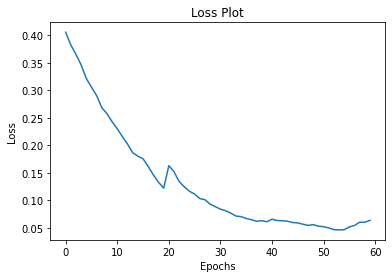

In [154]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


# Evaluation

In [155]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder([dec_input,
                                                         features,
                                                         hidden])

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [156]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Real Caption: <start> another lying politician <end>
Prediction Caption: this man having a professional job he is wearing ear rich <end>


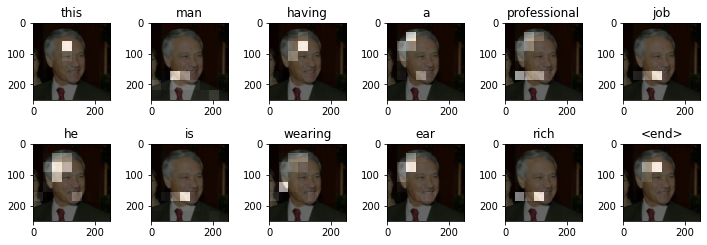

In [168]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


# Save Model

In [158]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
encoder.save_weights(saving_encoder_path)
decoder.save_weights(saving_decoder_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
